In [58]:
import autograd.numpy as np
from autograd import grad
import cvxpy as cp
import matplotlib.pyplot as plt

import pymanopt
import pymanopt.manifolds
import pymanopt.solvers
# from pymanopt.solvers import TrustRegions

from numpy.random import default_rng

import networkx as nx

In [59]:
def cost(Y):
    return -1/4 * np.trace(Y @ Y.T @ L)

In [60]:
def hyperplane_rounding(Y, cost, iter=100):
    min_cost = 0
    best_x = None
    d = Y.shape[1]
    rng = default_rng()
    for i in range(iter):
        r = rng.random((d,1))
        r = r / np.linalg.norm(r)
        x = np.sign(Y @ r)
        cost_val = cost(x)
        if cost_val < min_cost:
            min_cost = cost_val
            best_x = x
    return best_x, min_cost

In [61]:
# one iteration of elliptope optimization
def iterate_elliptope(rank, n, L, initial_Y=None):
    print("Current rank: %s"  %(rank))

    manifold = pymanopt.manifolds.Elliptope(n, rank)
    @pymanopt.function.Autograd(manifold)
    def manifold_cost(Y):
        return -1/4 * np.trace(Y @ Y.T @ L)

    problem = pymanopt.Problem(manifold=manifold, cost=manifold_cost)
    solver = pymanopt.solvers.SteepestDescent(minstepsize=1e-3)
    solution = solver.solve(problem, x=initial_Y)

    return solution, manifold_cost(solution)

In [62]:
def normalize_rows(X):
    # normalize the rows of matrix X
    return X / np.linalg.norm(X, axis=1)[:, np.newaxis]

In [63]:
# reduce rank via eignprojection and row normalization
def eigen_proj(Y):
    X = Y @ Y.T
    target_rank = np.linalg.matrix_rank(X, tol=1e-6) - 1
    Y_proj = Y
    if target_rank >= 1:
        eigen_values, eigen_vectors = np.linalg.eig(X)
        eigen_values = np.real(eigen_values)
        eigen_vectors = np.real(eigen_vectors)
        # sort by eigenvalues, from the largest to the smallest
        idx = eigen_values.argsort()[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:,idx]

        Y_proj = eigen_vectors[:, range(target_rank)] @ np.diag(np.sqrt(eigen_values[range(target_rank)]))
        Y_proj = normalize_rows(Y_proj)
    return Y_proj, target_rank

In [64]:
# reduce rank by optimizing over a manifold
def closest_point(Y):
    X = Y @ Y.T
    target_rank = np.linalg.matrix_rank(X, tol=1e-6) - 1
    Y_proj = Y
    if target_rank >= 2:
        manifold = pymanopt.manifolds.Elliptope(n, target_rank)
        @pymanopt.function.Autograd(manifold)
        def manifold_cost(Y):
            return np.trace(Y @ Y.T @ X)

        problem = pymanopt.Problem(manifold=manifold, cost=manifold_cost)
        solver = pymanopt.solvers.SteepestDescent(minstepsize=1e-3)
        Y_proj = solver.solve(problem)

    return Y_proj, target_rank

### Data

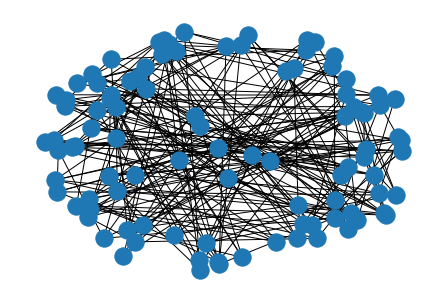

In [65]:
data_path = "../dat/"
# graph_file = "torusg3-8.dat"
graph_file = "toruspm3-8-50.dat"

with open(data_path + graph_file) as inf:
    next(inf, '')   # skip first line
    G = nx.read_weighted_edgelist(inf, nodetype=int, encoding="utf-8")

nx.draw(G.subgraph(range(100)))

In [66]:
n = len(G)
L = nx.laplacian_matrix(G).toarray() * 1.0
opt_sdp_rank = 34  # the optimal solution from the original BM method paper is 33

## Solve SDP relaxation

In [67]:
sdp_solution, sdp_cost = iterate_elliptope(opt_sdp_rank, n, L)

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -3.1904544254889533e-01    2.73876966e+01    
   2         -2.7663353120031310e+01    2.73254371e+01    
   3         -1.3287322465441849e+02    2.56502483e+01    
   4         -3.6019136546138935e+02    1.50767969e+01    
   5         -4.2201386246691345e+02    1.77774530e+01    
   6         -4.6996665754837142e+02    8.57959654e+00    
   7         -4.7737872972766758e+02    1.10951370e+01    
   8         -4.9426002937855731e+02    3.60998567e+00    
   9         -5.0735832291500276e+02    5.59378674e+00    
  10         -5.1168141925072155e+02    3.54958498e+00    
  11         -5.1376980143089918e+02    1.95554320e+00    
  12         -5.1448101096247547e+02    4.06888272e+00    
  13         -5.1641442000878305e+02    1.68586949e+00    
  14         -5.1707706323852381e+02    2.32904478e+00    
  15         -5.176988588

## Manifold iteration

### Eigenprojection + hyperplane rounding

In [78]:
eigen_proj_ranks = []
eigen_proj_costs = []

rank_new = opt_sdp_rank
Y_new = None
solution_new = None
while (rank_new > 1):
    solution_new, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    eigen_proj_ranks += [rank_new]
    eigen_proj_costs += [-cost_val]
    Y_new, rank_new = eigen_proj(solution_new)
eigen_proj_solution, eigen_proj_cost = hyperplane_rounding(solution_new, cost)
eigen_proj_simple_rounding_cost = cost(Y_new)
eigen_proj_ranks += [1, 1]
eigen_proj_costs += [-eigen_proj_cost, -eigen_proj_simple_rounding_cost]

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +7.1886249371912836e-01    2.74373190e+01    
   2         -2.6678453235325684e+01    2.73823959e+01    
   3         -1.3216155001020641e+02    2.57460143e+01    
   4         -3.6167094170858195e+02    1.51741270e+01    
   5         -4.2394545813956825e+02    1.75910598e+01    
   6         -4.7002635358460122e+02    8.99200751e+00    
   7         -4.7990219524233532e+02    9.88127604e+00    
   8         -4.9209449169883618e+02    6.66812430e+00    
   9         -4.9588795862049778e+02    7.72254334e+00    
  10         -5.0405987384546512e+02    2.77467212e+00    
  11         -5.0746512121182280e+02    8.83156341e+00    
  12         -5.1635082254408314e+02    3.11529224e+00    
  13         -5.1831910010531146e+02    2.64821724e+00    
  14         -5.1898252480831218e+02    3.31975099e+00    
  15         -5.204041045

### Closest point + hyperplane rounding

In [69]:
closest_point_ranks = []
closest_point_costs = []

rank_new = opt_sdp_rank
Y_new = None
solution_new = None
while (rank_new > 1):
    solution_new, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    closest_point_ranks += [rank_new]
    closest_point_costs += [-cost_val]
    Y_new, rank_new = closest_point(solution_new)
closest_point_solution, closest_point_cost = hyperplane_rounding(solution_new, cost)
closest_point_ranks += [1]
closest_point_costs += [-closest_point_cost]

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +5.6545634878863504e+00    2.74046143e+01    
   2         -2.1708229430809624e+01    2.73457431e+01    
   3         -1.2699344210946546e+02    2.56764087e+01    
   4         -3.5478031832739339e+02    1.52238911e+01    
   5         -4.2062141810582887e+02    1.74854068e+01    
   6         -4.6511689561563230e+02    1.01883845e+01    
   7         -4.8151842140945007e+02    7.34154735e+00    
   8         -4.8732486187417067e+02    9.14903055e+00    
   9         -4.9905172851174478e+02    3.39524735e+00    
  10         -5.0257851255970479e+02    9.37584861e+00    
  11         -5.1204661189696628e+02    3.42372865e+00    
  12         -5.1369713352314693e+02    2.70509964e+00    
  13         -5.1484922906224426e+02    2.56349030e+00    
  14         -5.1595467653779815e+02    1.79017671e+00    
  15         -5.168032986

## Benchmark: hyperplane rounding of SDP solution

In [70]:
_, hyperplane_rounding_cost= hyperplane_rounding(sdp_solution, cost)

### Benchmark: greedy one-exchange

In [71]:
from networkx.algorithms.approximation import maxcut
one_exchange_cost = maxcut.one_exchange(G, weight="weight", initial_cut=None)[0]

## Plots

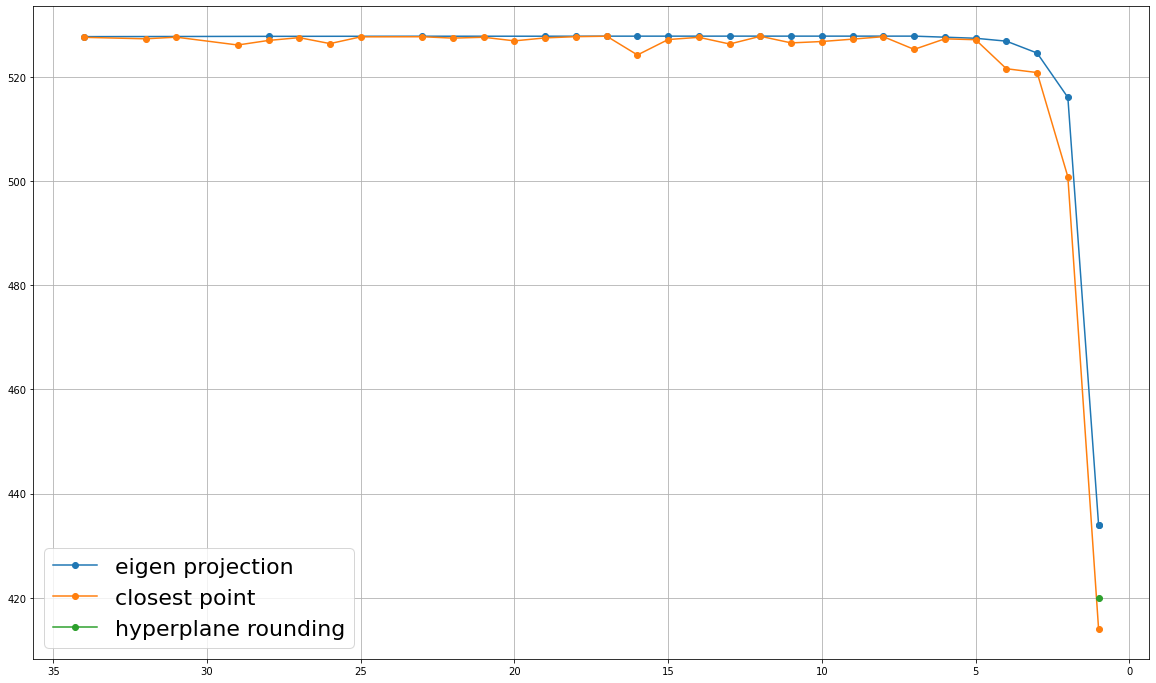

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)
ax.invert_xaxis()

plt.plot(eigen_proj_ranks, eigen_proj_costs, label="eigen projection", marker="o")
plt.plot(closest_point_ranks, closest_point_costs, label="closest point", marker="o")

plt.plot([1], [-hyperplane_rounding_cost], label="hyperplane rounding", marker="o")

plt.legend(loc='lower left', fontsize=22)
plt.grid()